In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from robust_PDE_FIND import RobustPCA
from best_subset import *
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff

from sklearn.decomposition import PCA, TruncatedSVD
from skimage.restoration import denoise_wavelet, estimate_sigma

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([-1, -1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.2.2


#### Load data

In [2]:
data = sio.loadmat('../Datasets/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Visualization

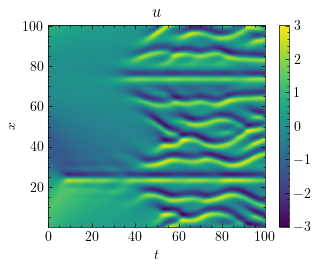

In [3]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, u, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("$u$")
    cbar = ufig.colorbar(contour)
    ufig.savefig("../Figures/ks.png", dpi=300)
    plt.show()

#### Add noise

In [4]:
np.random.seed(0)
noise_lv = 30
un = u + 0.01*noise_lv*u.std()*np.random.randn(u.shape[0],u.shape[1])
np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf)

(162.06280991002185, 73.75161772179317)

#### Use the precomputed denoised variable given by the K-SVD

In [5]:
is_u_denoised = True
if is_u_denoised:
    print("Loading denoised data...")
    denoised_un = np.load("../Examples/denoised_files/KS_noise30_reduced_dctV2ksvdreg_25x25.npy")
    un = denoised_un
    
    ### PCA ###
#     target_percentage = 95
#     summ = 0.0
#     n_components = 0
#     sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     for s in sigma:
#         summ += s
#         n_components += 1
#         if summ > target_percentage/100:
#             break
#     print(n_components, summ)
#     assert n_components < len(sigma)
#     pca = PCA(n_components=n_components).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un

    ### Revised PCA ###
#     target_percentage = 99.5
#     Sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     # sigma = Sigma/Sigma.sum() # if .explained_variance_ is used above
#     summ = np.cumsum(100*Sigma)
#     n_components = np.argmax(summ>target_percentage)+1
#     assert n_components < len(Sigma)
#     print(n_components, summ[n_components-1])
#     pca = PCA(n_components=n_components).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un
    
    ### SVD ###
#     target_percentage = 99.99 # 90, 95, 99.99
#     U, Sigma, V = np.linalg.svd(un, full_matrices=False); V = V.T
#     sigma = (Sigma.copy())**2
#     sigma = sigma/sigma.sum()
#     summ = np.cumsum(100*sigma)
#     n_components = np.argmax(summ>target_percentage)+1
#     assert n_components < len(Sigma)
#     svd_un = U[:, 0:n_components].dot(np.diag(Sigma[0:n_components]).dot(V[:,0:n_components].T))
#     print(n_components, summ[n_components-1])
#     un = svd_un
    
    ### Wavelet denoising ###
#     wavelet_un = denoise_wavelet(un, channel_axis=None, convert2ycbcr=False, 
#                                  sigma=estimate_sigma(un, channel_axis=None, average_sigmas=True), 
#                                  method='BayesShrink', mode='soft', rescale_sigma=True)
#     un = wavelet_un

    ### Robust PCA ###
#     rpca_lam = 0.1
#     un, _ = RobustPCA(un, rpca_lam)

    ### FFT ###
#     def remove_f(uu, percent):
#         if percent <= 0: return uu
#         # PSD = (uu*np.conj(uu)) # also valid
#         PSD = (uu*np.conj(uu))/np.prod(uu[0, :].shape)
#         PSD = PSD.real
#         mask = (PSD>=np.percentile(PSD, percent)).astype(np.float32)
#         return uu*mask
#     remove_percent = 50
#     un = ifft(remove_f(fft(un), remove_percent)).real
    
    l_F, l_inf = np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf)
    print(l_F, l_inf)

Loading denoised data...
27.108105914029274 17.881259094044502


In [6]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = -0.994 x0_11 + -0.996 x0_1111 + -0.992 x0x0_1


#### Applying best-subset regression on the weak formulation

In [7]:
class FiniteDifferentiator(ps.BaseDifferentiation):
    def __init__(self, acc=2, d=1, axis=1, is_uniform=True, periodic=False):
        super(FiniteDifferentiator, self).__init__()        
        self.acc = acc
        self.d = d
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        
    def _differentiate(self, x, t):
        if self.is_uniform:
            if isinstance(t, float): 
                dt = t
            else: 
                dt = t[1]-t[0]
            self.diff = FinDiff(self.axis, dt, self.d, acc=self.acc)
        else:
            raise NotImplementedError("is_uniform=False")
            self.diff = FinDiff(self.axis, self.d, acc=self.acc)
        return self.diff(x)

# differentiation_method, differentiation_kwargs = FiniteDifferentiator, {'acc':4}
diff_order = 4
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=4, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
#                                  differentiation_method=differentiation_method, 
#                                  differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}

In [8]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=4, lam=5e-2, is_normal=True, normalize_columns=False, threshold=1e-4)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=3, alpha=5e-2, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt)
print(model.get_feature_names())
X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04
['u', 'uu', 'u_1', 'u_11', 'u_111', 'u_1111', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11', 'uu_111', 'uuu_111', 'uu_1111', 'uuu_1111']


In [9]:
print("From brute-force solver")
best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0]) 
                for i in range(1, X_pre.shape[1]+1)]
best_subsets

From brute-force solver


[(6,),
 (6, 9),
 (3, 5, 6),
 (3, 5, 6, 9),
 (0, 3, 5, 6, 13),
 (0, 3, 5, 6, 9, 13),
 (0, 1, 3, 5, 6, 8, 13),
 (0, 1, 3, 4, 5, 6, 8, 13),
 (0, 1, 3, 4, 5, 6, 8, 12, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3; per = 75
scale = np.log(len(y_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets])
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])        
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(max(lower_bounds/(b_uns*scale)), 1e-6))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
    if min(last_bc, now_bc) > 0:
        if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp > thres):
            break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

if last_lam >= 0: last_lam = abs(last_lam)    
last_lam, last_ubic, last_bc

threshold: 1.1857509769860886
2 <---> 2 inf
2 <---> 2 inf
2 <---> 2 inf


(0.0,
 array([ 30389.6021943 ,  25273.87744734, -13229.10564322, -13224.80209202,
        -13226.45510797, -13219.24181963, -13213.94492246, -13212.05614042,
        -13206.1384973 , -13198.96090131, -13187.39748315, -13175.30117266,
        -13164.91757264, -13152.68299442]),
 2)

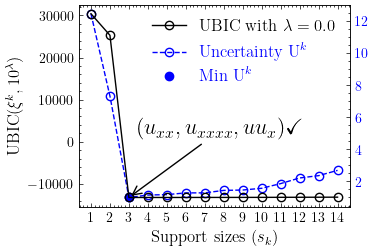

In [11]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.annotate('$(u_{xx}, u_{xxxx}, uu_{x})\checkmark$', fontsize=16, 
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+15000), 
                 arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam,2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper right', fontsize=12)
    
    plt.show()

#### Percent coefficient error

In [12]:
# print(n_components, summ[n_components-1])
print(l_F, l_inf)
# (0.38132791930786114, 0.07431246710249238)
evaluate_coefficients(np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], 
                                      y_pre, rcond=None)[0].flatten())

27.108105914029274 17.881259094044502


(0.41585679763212297, 0.232846230739623)

In [13]:
# rksvd: 27.108105914029274 17.881259094044502 | (0.38132791930786114, 0.07431246710249238)
# svd n_comp=192: 153.5694003779047 70.4727518536003 | (0.4770795565998391, 0.05126869446362347)
# svd n_comp=219: 158.23781365673557 72.1093837870622 | (0.48901137295295216, 0.044459083509319104)
# svd 99.5: 161.7902210250776 73.57315056503592 | (0.45361907935370277, 0.044801228368466305)
# pca n_comp=11: 81.07475613978701 52.398364719300496 | (10.447512017229533, 1.299790682493709)
# pca n_comp=64: 102.7364866487135 52.11722373743241 | (0.17633955063914852, 0.15096588628914304)
# pca 99.5: 162.0628099100219 73.75161772179311 | (0.45080739194979974, 0.04618288300016542)
# Robust PCA: 161.86722972349637 73.73114135286613 | (0.45250708452467076, 0.053166699858169235)
# wavelet: 62.446693154177936 46.00486286154634 | (0.8626882277887363, 0.4305231755173573)
# FFT_{10}: 89.17074613617577 52.51716589187471 | (0.23069465444017778, 0.15343539180242924)
# FFT_{25}: 123.05702085125361 63.950668250721364 | (0.1575733543413412, 0.04243675368151098)
# FFT_{50}: 148.51913887859433 68.97187431581114 | (0.33927402621379094, 0.06320521493280676)

### revised SVD (max = 99.99) ###
# 11 90.58056831009351
# 80.93084312550653 52.53120822774363 -> (11.871965187426836, 1.4129213293772145)
# 64 95.03626587328853
# 103.44739944812825 52.504357601656494 -> (0.40793972647637694, 0.09454447413911003)
# 212 99.50167194924107
# 157.15582036862432 71.32678811178369 -> (0.48389934424521625, 0.04578413089293387)
# 250 99.99097304248765
# 161.9745092789074 73.590975949445 -> (0.44653190635015233, 0.04466240482875186)
### revised PCA (max = 99.5) ###
# 11 90.5871676484704
# 81.07475613978701 52.398364719300496
# (10.447512017229533, 1.299790682493709)
# 64 95.0410544512504
# 102.7364866487135 52.11722373743241
# (0.17633955063914852, 0.15096588628914304)
# 212 99.50215317963874
# 157.16059836589847 71.34593333336375
# (0.48184447400837865, 0.04677536789429592)

#### Strategy I

In [14]:
from tools import *
from derivative import dxdt

In [15]:
fft_percent = 0
n_modes = 20
acc = 8
include_bias = False

# uu = u.copy()
uu = un.copy()
# uu = POD(un, n_modes)
# uu = ROM(un, t, n_modes, "DMD")
# uu = ROM(un, t, n_modes, "BOPDMD", num_trials=0, tol=None)

# automate this...
# d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(uu)
# d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(uu)
# d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(uu)
# d_dxxxx = FinDiff(0, dx, 4, acc=acc); u_xxxx = d_dxxxx(uu)
# d_dt = FinDiff(1, dt, 1, acc=acc); u_t = d_dt(uu)

# automate this...
diff_spec = {"kind":"kalman", "alpha":5e-2}
# diff_spec = {"kind":"trend_filtered", "order":0, "alpha":1e-2}
d_dt = lambda _: dxdt(_, t, axis=1, **diff_spec)
d_dx = lambda _: dxdt(_, x, axis=0, **diff_spec)
u_x = d_dx(uu)
u_xx = d_dx(u_x)
u_xxx = d_dx(u_xx)
u_xxxx = d_dx(u_xxx)
u_t = d_dt(uu)

In [16]:
poly_deg = 2
phi1 = [u**i for i in range(0, poly_deg+1)]; phi1_names = ["", "u", "u^{2}"]
phi2 = [u_x, u_xx, u_xxx, u_xxxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}", "u_{xxxx}"]
phi = phi1.copy(); phi_names = phi1_names.copy()
phi.extend(phi2); phi_names.extend(phi2_names)
phi.extend([p1*p2 for p2 in phi2 for p1 in phi1[1:]])
phi = np.array(phi)
phi_names.extend([p1+p2 for p2 in phi2_names for p1 in phi1_names[1:]])
fft_phi = [np.fft.fft(_, axis=-1) for _ in phi]
fft_u_t = np.fft.fft(u_t, axis=-1)

Theta_grouped = np.moveaxis(phi, 0, -1)
Ut_grouped = np.expand_dims(u_t, -1)
rhs_des = phi_names
fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

del phi1, phi2, phi1_names, phi2_names

X_fft, y_fft = fft_Theta_grouped.reshape(-1, len(phi_names)), fft_Ut_grouped.reshape(-1, 1)

print("PDE derived using STRidge")
print_pde(TrainSTRidge(X_fft, 
                       y_fft, 
                       10**-5, 1), 
          phi_names)

if not include_bias:
    X_fft = X_fft[:, 1:]
    phi_names = phi_names[1:]

PDE derived using STRidge
l0_penalty: 0.03014051185625786
u_t = (-0.001663 +0.000659i)
    + (0.023717 -0.000321i)u
    + (0.002482 -0.000242i)u^{2}
    + (-0.001225 -0.000549i)u_{x}
    + (-0.084027 -0.002554i)u_{xx}
    + (0.002236 -0.001462i)u_{xxx}
    + (-0.138373 -0.000939i)u_{xxxx}
    + (-0.283567 +0.001187i)uu_{x}
    + (0.000778 -0.000277i)u^{2}u_{x}
    + (0.001657 +0.001427i)uu_{xx}
    + (0.035360 +0.000289i)u^{2}u_{xx}
    + (-0.105572 +0.000730i)uu_{xxx}
    + (0.000606 -0.000402i)u^{2}u_{xxx}
    + (-0.001493 +0.000513i)uu_{xxxx}
    + (0.013663 +0.000576i)u^{2}u_{xxxx}
   


In [17]:
best_ws = []
for com in range(1, len(best_subsets)+1):
    w = np.zeros((X_pre.shape[-1], 1))
    eff_indices = best_subsets[com-1]
    # V1 -> kalman_alpha should be tuned so that V1 close to V2
    # w[eff_indices, :] = np.linalg.lstsq(X_fft[:, eff_indices], y_fft, rcond=None)[0]
    # V2 -> kalman_alpha should be tuned so that V2 close to V1
    w[eff_indices, :] = np.linalg.lstsq(X_pre[:, eff_indices], y_pre, rcond=None)[0]
    best_ws.append(w)
best_ws = np.hstack(best_ws)

[2694894.1670279847, 2694142.960768091, 2693816.639050469, 2693828.262027476, 2693839.7763207257, 2693851.846651439, 2693864.7834484424, 2693876.9100344055, 2693889.3982131635, 2693901.4587500333, 2693913.8944843654, 2693926.404558142, 2693938.8695248323, 2693951.3264228525]
3


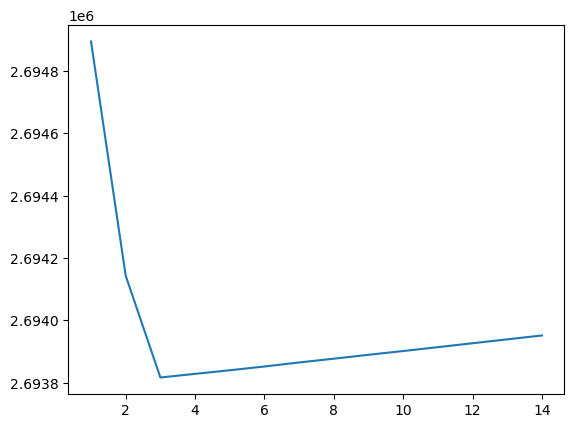

In [18]:
b_bics = []
rss_list = []
nfft = None # len(y_pre)
ground = periodogram_f(fft_Ut_grouped[:, :, 0], nfft=nfft).reshape(-1, 1)

for com in range(1, len(best_subsets)+1):
    w = best_ws[:, com-1:com]
    pred = X_fft@w
    pred = periodogram_f(ifft(pred.reshape(uu.shape)), nfft=nfft).reshape(-1, 1)
    rss = 2*np.pi*sum_squared_residuals(pred, ground)/len(ground)
    rss_list.append(rss)
    
min_epsilon = 1e-5
epsilon = max(min_epsilon, 10**(convert_to_scientific_notation(max(rss_list))[-1]))
epsilon = 1e-5

for com in range(1, len(best_subsets)+1):
    w = best_ws[:, com-1:com]
    pred = X_fft@w
    pred = periodogram_f(ifft(pred.reshape(uu.shape)), nfft=nfft).reshape(-1, 1)
    b_bics.append(mbic(pred, ground, com, epsilon))
    
print(b_bics)
print(np.argmin(b_bics)+1)
plt.plot(complexity_axis, b_bics); plt.show()

In [19]:
tau = 3
verbose = True
scale = np.log(len(y_fft))
# scale = 1 <- generalized UBIC
per = 75 # 75, 85, 95

post_means, _, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_fft@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(periodogram_f(ifft(predictions[:, k:k+1].reshape(uu.shape)), nfft=nfft).reshape(-1, 1), 
                                          ground, epsilon))-np.log(len(y_fft))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_fft), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_fft), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if min(last_bc, now_bc) > 0:
        if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp >= thres):
            break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc
    
last_lam = round(last_lam, 10)
if last_lam >= 0: last_lam = abs(last_lam)
last_lam, last_ubic, last_bc

threshold: 0.00023934441628154952
max_lam: 5.334945140147001
2 <---> 2 inf
2 <---> 2 inf
2 <---> 2 inf


(0.0,
 array([2695049.3882644 , 2694234.22246849, 2693829.09597521,
        2693842.62562816, 2693854.45881101, 2693867.87397467,
        2693880.83390469, 2693894.87312989, 2693907.65708968,
        2693921.06442532, 2693937.1513587 , 2693954.02839981,
        2693968.30096177, 2693984.84826845]),
 2)

In [20]:
# n_pow = 3
# b_bics = []
# for com in range(1, len(best_subsets)+1):
#     b_bics.append(mbic((X_pre@best_ws[:, com-1:com])**n_pow, 
#                        y_pre**n_pow, com, epsilon=1e-5))
# print(b_bics)
# print(np.argmin(b_bics)+1)
# plt.plot(complexity_axis, b_bics); plt.show()

[30274.84865097253, 25206.422713073025, -13237.291737153111, -13234.39729258119, -13236.284945362533, -13230.065690303763, -13224.78548945117, -13224.309968023808, -13218.610657165826, -13212.428543554694, -13203.564695546136, -13194.697176849826, -13185.650051060795, -13176.439819285515]
3


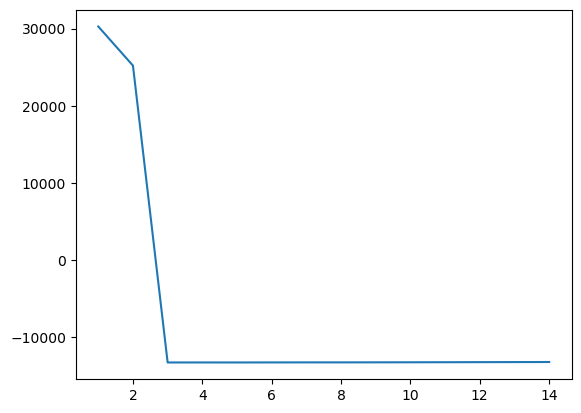

In [21]:
n_pow = 1
b_bics = []
rss_list = []
for com in range(1, len(best_subsets)+1):
    rss = 2*np.pi*sum_squared_residuals(X_pre@best_ws[:, com-1:com]**n_pow, 
                                        y_pre**n_pow)/len(ground)
    rss_list.append(rss)
min_epsilon = 1e-5
epsilon = max(min_epsilon, 10**(convert_to_scientific_notation(max(rss_list))[-1]))
epsilon = 1e-5
for com in range(1, len(best_subsets)+1):    
    b_bics.append(mbic((X_pre@best_ws[:, com-1:com])**n_pow, 
                       y_pre**n_pow, com, epsilon=epsilon))
print(b_bics)
print(np.argmin(b_bics)+1)
plt.plot(complexity_axis, b_bics); plt.show()

In [22]:
tau = 3
verbose = True
scale = np.log(len(y_pre))
# scale = 1 <- generalized UBIC
per = 75 # 75, 85, 95

post_means, _, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1]**n_pow, y_pre**n_pow, epsilon))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if min(last_bc, now_bc) > 0:
        if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp >= thres):
            break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
if last_lam >=0: last_lam = abs(last_lam)
last_lam, last_ubic, last_bc, best_bc

threshold: 1.1857200688242069
max_lam: 3.157523460327879
2 <---> 2 inf
2 <---> 2 inf
2 <---> 2 inf


(0.0,
 array([ 30389.61537306,  25273.89934481, -13228.08139678, -13223.77720344,
        -13225.42907718, -13218.21548608, -13212.91818125, -13211.02850193,
        -13205.11049794, -13197.93259481, -13186.36914102, -13174.27279529,
        -13163.8891785 , -13151.65460029]),
 2,
 2)

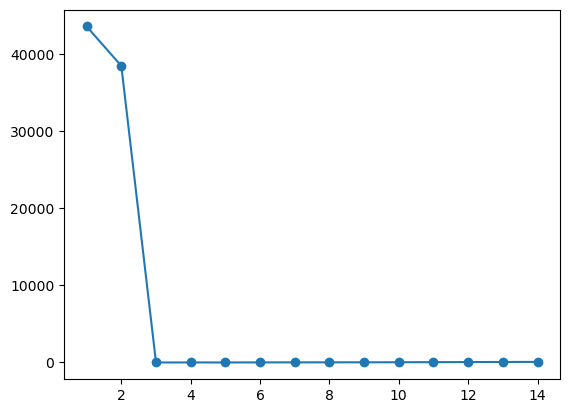

In [23]:
plt.plot(complexity_axis, last_ubic-min(last_ubic), '-o'); plt.show()

In [24]:
import metric_learn
from sklearn.manifold import TSNE
from scipy.stats import wilcoxon

def plot_tsne(X, y, colormap=plt.cm.Paired):
    plt.figure(figsize=(8, 6))

    # clean the figure
    plt.clf()

    tsne = TSNE()
    X_embedded = tsne.fit_transform(X)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=colormap)

    plt.xticks(())
    plt.yticks(())

    plt.show()
    
# plot_tsne(X_pre, y_pre.flatten(), plt.cm.Oranges)

In [25]:
for now_com in range(1, len(best_subsets)):
    n_learn = 2000; max_iterations = 30
    left_indices = set(np.arange(len(X_pre)))
    it = 0
    base_performance = []
    new_performance = []
    while len(left_indices) >= n_learn and it < max_iterations:
        choosen_indices = np.random.choice(sorted(left_indices), n_learn)
        y_new = y_pre[choosen_indices]
        baseline_perf = sm.OLS(y_new, X_pre[list(choosen_indices), :][:, best_subsets[now_com-1]]).fit().bic
        base_performance.append(baseline_perf)
        new_perf = sm.OLS(y_new, X_pre[list(choosen_indices), :][:, best_subsets[now_com]]).fit().bic
        new_performance.append(new_perf)
        it += 1

    w_res = wilcoxon(new_performance, base_performance, alternative='less')
    print(now_com, now_com+1, w_res.pvalue)

1 2 9.313225746154785e-10
2 3 9.313225746154785e-10
3 4 0.999999993480742
4 5 0.9912731656804681
5 6 0.9999997643753886
6 7 0.9999974276870489
7 8 0.9999996544793248
8 9 0.9999999906867743
9 10 1.0
10 11 0.9999999180436134
11 12 1.0
12 13 1.0
13 14 1.0


In [26]:
assert 0 == 1

AssertionError: 

In [ ]:
# #terms: 1
# 0.7269501862357183 1.207661019061881
# #terms: 2
# 0.015537923241294953 0.7268180899404292
# #terms: 3
# 0.015528947067301397 0.015537920374905156

# # how about sampling a small set of samples repeatedly (for fast MLKR) -> significant testing?
# thres_perf = 1e-3
# for com in range(1, len(best_subsets)):
#     print("#terms:", com)
#     base_indices = best_subsets[com-1]
#     X_org = X_pre[:, base_indices]
#     baseline_perf = mean_squared_error(y_pre, 
#                                        X_org@np.linalg.lstsq(X_org, y_pre, rcond=None)[0])
#     mlkr = metric_learn.MLKR(n_components=len(base_indices))
#     X_mlkr = mlkr.fit_transform(X_pre[:, best_subsets[com]], y_pre)
#     new_perf = mean_squared_error(y_pre, X_mlkr@np.linalg.lstsq(X_mlkr, y_pre, rcond=None)[0])
#     print(new_perf, baseline_perf)
#     if (baseline_perf-new_perf)/baseline_perf < thres_perf:
#         break

In [ ]:
n_learn = 2000; max_iterations = 30
left_indices = set(np.arange(len(X_pre)))
it = 0
now_com = 2 # 3
base_performance = []
new_performance = []
while it < max_iterations: 
    choosen_indices = np.random.choice(sorted(left_indices), n_learn)
    # left_indices -= set(choosen_indices)
    y_new = y_pre[choosen_indices]
    
    base_indices = best_subsets[now_com-1]
    X_org = X_pre[list(choosen_indices), :][:, base_indices]
    baseline_perf = mean_squared_error(y_new, 
                                       X_org@np.linalg.lstsq(X_org, y_new, rcond=None)[0])
    base_performance.append(baseline_perf)
    
    mlkr = metric_learn.MLKR(n_components=len(base_indices))
    X_new = X_pre[list(choosen_indices), :][:, best_subsets[now_com]]
    X_mlkr = mlkr.fit_transform(X_new, y_new)
    new_perf = mean_squared_error(y_new, X_mlkr@np.linalg.lstsq(X_mlkr, y_new, rcond=None)[0])
    new_performance.append(new_perf)
    
    print(baseline_perf, new_perf)    
    it += 1
    
wilcoxon(new_performance, base_performance, alternative='less')

In [ ]:
n_learn = 2000; max_iterations = 30
left_indices = set(np.arange(len(X_pre)))
it = 0
now_com = 3 # 3
base_performance = []
new_performance = []
while it < max_iterations: 
    choosen_indices = np.random.choice(sorted(left_indices), n_learn)
    # left_indices -= set(choosen_indices)
    y_new = y_pre[choosen_indices]
    
    base_indices = best_subsets[now_com-1]
    X_org = X_pre[list(choosen_indices), :][:, base_indices]
    baseline_perf = mean_squared_error(y_new, 
                                       X_org@np.linalg.lstsq(X_org, y_new, rcond=None)[0])
    base_performance.append(baseline_perf)
    
    mlkr = metric_learn.MLKR(n_components=len(base_indices))
    X_new = X_pre[list(choosen_indices), :][:, best_subsets[now_com]]
    X_mlkr = mlkr.fit_transform(X_new, y_new)
    new_perf = mean_squared_error(y_new, X_mlkr@np.linalg.lstsq(X_mlkr, y_new, rcond=None)[0])
    new_performance.append(new_perf)
    
    print(baseline_perf, new_perf)    
    it += 1
    
wilcoxon(new_performance, base_performance, alternative='less')